<a href="https://colab.research.google.com/github/arnavkapasiuf/BME3053C-Spring-2025/blob/main/homework/Homework_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.signal import find_peaks

In [2]:
def generate_ecg_data(duration, sampling_rate=250):
    def generate_ecg_pulse(duration, sampling_rate):
        t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)
        # P wave
        p_wave = 0.15 * np.sin(2 * np.pi * 1.5 * t) * np.exp(-((t - 0.1) ** 2) / 0.005)
        # QRS complex
        qrs_complex = np.zeros_like(t)
        qrs_complex[(t > 0.2) & (t < 0.25)] = -0.3
        qrs_complex[(t > 0.25) & (t < 0.3)] = 1.0
        qrs_complex[(t > 0.3) & (t < 0.35)] = -0.2
        # T wave
        t_wave = 0.3 * np.sin(2 * np.pi * 0.75 * (t - 0.45)) * np.exp(-((t - 0.45) ** 2) / 0.015)
        # Combine all components
        pulse = p_wave + qrs_complex + t_wave
        # Add high-frequency noise to the pulse
        high_freq_noise = 0.05 * np.sin(2 * np.pi * 50 * t)
        pulse += high_freq_noise
        return pulse


    # Generate a single ECG pulse
    single_pulse = generate_ecg_pulse(0.8, sampling_rate)


    # Repeat the pulse to create a longer ECG signal
    num_pulses = int(duration / 0.8)
    ecg_data = np.tile(single_pulse, num_pulses)


    # Add more noise to make it more realistic
    noise = np.random.normal(0, 0.05, len(ecg_data))  # Increased noise amplitude
    ecg_data += noise


    # Add baseline wander
    t = np.linspace(0, duration, len(ecg_data), endpoint=False)
    baseline_wander = 0.1 * np.sin(2 * np.pi * 0.1 * t)
    ecg_data += baseline_wander


    # Add power line interference
    power_line_interference = 0.05 * np.sin(2 * np.pi * 60 * t)  # 60 Hz interference
    ecg_data += power_line_interference


    # Ensure the length of ecg_data matches the desired duration
    ecg_data = ecg_data[:int(duration * sampling_rate)]


    return ecg_data


ecg_data = generate_ecg_data(10, 250)
def generate_ecg_data(duration, sampling_rate=250):
    def generate_ecg_pulse(duration, sampling_rate):
        t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)
        # P wave
        p_wave = 0.15 * np.sin(2 * np.pi * 1.5 * t) * np.exp(-((t - 0.1) ** 2) / 0.005)
        # QRS complex
        qrs_complex = np.zeros_like(t)
        qrs_complex[(t > 0.2) & (t < 0.25)] = -0.3
        qrs_complex[(t > 0.25) & (t < 0.3)] = 1.0
        qrs_complex[(t > 0.3) & (t < 0.35)] = -0.2
        # T wave
        t_wave = 0.3 * np.sin(2 * np.pi * 0.75 * (t - 0.45)) * np.exp(-((t - 0.45) ** 2) / 0.015)
        # Combine all components
        pulse = p_wave + qrs_complex + t_wave
        # Add high-frequency noise to the pulse
        high_freq_noise = 0.05 * np.sin(2 * np.pi * 50 * t)
        pulse += high_freq_noise
        return pulse

    # Generate a single ECG pulse
    single_pulse = generate_ecg_pulse(0.8, sampling_rate)

    # Repeat the pulse to create a longer ECG signal
    num_pulses = int(duration / 0.8)
    ecg_data = np.tile(single_pulse, num_pulses)

    # Add more noise to make it more realistic
    noise = np.random.normal(0, 0.05, len(ecg_data))  # Increased noise amplitude
    ecg_data += noise

    # Add baseline wander
    t = np.linspace(0, duration, len(ecg_data), endpoint=False)
    baseline_wander = 0.1 * np.sin(2 * np.pi * 0.1 * t)
    ecg_data += baseline_wander

    # Add power line interference
    power_line_interference = 0.05 * np.sin(2 * np.pi * 60 * t)  # 60 Hz interference
    ecg_data += power_line_interference

    # Ensure the length of ecg_data matches the desired duration
    ecg_data = ecg_data[:int(duration * sampling_rate)]

    return ecg_data

ecg_data = generate_ecg_data(10, 250)

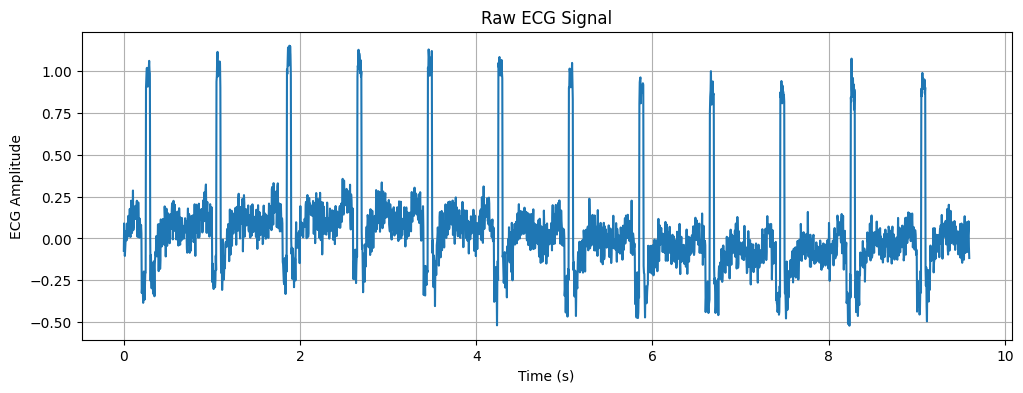

In [4]:
sampling_rate = 250
duration = 10
ecg_data = generate_ecg_data(duration, sampling_rate)

time = np.arange(len(ecg_data)) / sampling_rate

plt.figure(figsize=(12, 4))
plt.plot(time, ecg_data)
plt.title("Raw ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("ECG Amplitude")
plt.grid(True)
plt.show()

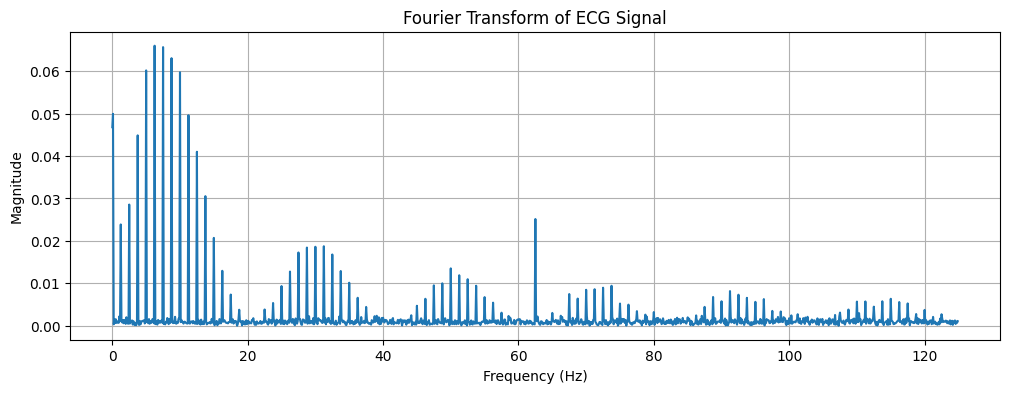

In [5]:
N = len(ecg_data)
ecg_fft = fft(ecg_data)
frequencies = np.fft.fftfreq(N, d=1/sampling_rate)
magnitude = np.abs(ecg_fft) / N

# Only plot positive frequencies
half_N = N // 2

plt.figure(figsize=(12, 4))
plt.plot(frequencies[:half_N], magnitude[:half_N])
plt.title("Fourier Transform of ECG Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

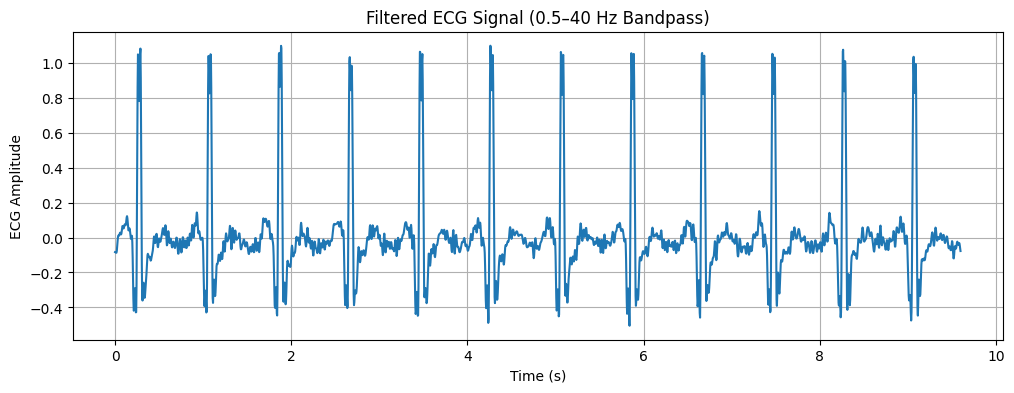

In [6]:
# Create bandpass filter mask
bandpass_mask = (frequencies >= 0.5) & (frequencies <= 40)
# Symmetric negative frequencies
bandpass_mask |= (frequencies <= -0.5) & (frequencies >= -40)

filtered_fft = ecg_fft * bandpass_mask
filtered_ecg = np.real(ifft(filtered_fft))

plt.figure(figsize=(12, 4))
plt.plot(time, filtered_ecg)
plt.title("Filtered ECG Signal (0.5–40 Hz Bandpass)")
plt.xlabel("Time (s)")
plt.ylabel("ECG Amplitude")
plt.grid(True)
plt.show()

Estimated Heart Rate: 75.21 BPM


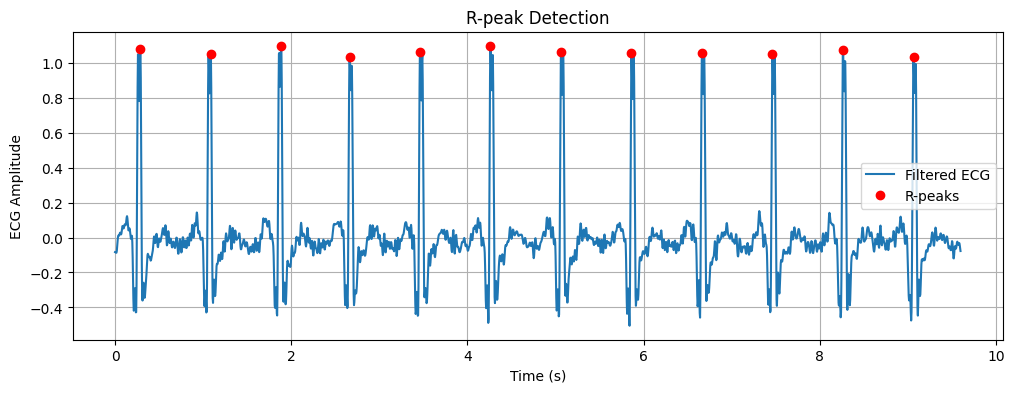

In [7]:
# Find R-peaks
peaks, _ = find_peaks(filtered_ecg, distance=0.4*sampling_rate, height=0.5)

# Calculate intervals between peaks
peak_times = time[peaks]
rr_intervals = np.diff(peak_times)

# Average heart rate
average_rr = np.mean(rr_intervals)
heart_rate = 60 / average_rr

print(f"Estimated Heart Rate: {heart_rate:.2f} BPM")

# Optional: plot R-peaks
plt.figure(figsize=(12, 4))
plt.plot(time, filtered_ecg, label='Filtered ECG')
plt.plot(peak_times, filtered_ecg[peaks], 'ro', label='R-peaks')
plt.title("R-peak Detection")
plt.xlabel("Time (s)")
plt.ylabel("ECG Amplitude")
plt.legend()
plt.grid(True)
plt.show()

After generating and analyzing the raw artificial ECG data, I was able to recognize the necessary components that must be present within an ECG like QRS complexes, PR/QT intervals, and the PR/ST segments. However, a lot of these components were difficult to easily identify and analyze due to the background noise that is present within the ECG. In order to minimize some of that information we were able to apply a Fourier transformation that organized that data and told us how the magnitude changed in accordance to increasing frequency changes. Furthermore by applying a bandpass filter to the Fourier transformation we are able to clear more background noise by minimizing to only include those frequencies between 0.5 and 4o Hz in order to clear any frequencies that might be low or high outliers, resulting in a clearer ECG signal. Finally, by detecting R-peaks we are able to estimate the heart rate which after analyzing the data we are able to determine that the heart rate is within normal physiological range. Overall, by applying all these methods we are able to clear any unecessary background noise and make the process more efficient.